In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

from utils import device_setting, seed_torch
from data_manager import AnomalyDataManager
from model import ResNet50MetricModel, MLP
from metric_layer import ArcMarginProduct
from resnet import ResNet18
# from trainer import Trainer

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import numpy as np
import matplotlib

In [2]:
data_dir = '../data'
dataset = 'kdd'
batch_size = 64
lr = 0.001
momentum = 0.9
max_epoch = 200
criterion = nn.CrossEntropyLoss()
feature_dim = 128
gpu = 0
device = device_setting(gpu=gpu)

In [3]:
data_manager = AnomalyDataManager(dataset=dataset, data_dir=data_dir, trans=None, anomaly_label=9, data_num=2000)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target', 'level']
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37])


In [4]:
dataset_dict = data_manager.get_dataset()
# dataset_dict['train'][0]

In [5]:
dataset_dict['train'][:][0].size()

torch.Size([25192, 119])

In [13]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)

X_embedded = tsne.fit_transform(dataset_dict['test'][:][0].detach().numpy())

C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

In [15]:
X_embedded[:, 0]

array([ 18.380621,  25.772371,  59.226692, ..., -49.53698 , -23.954746,
       -28.05705 ], dtype=float32)

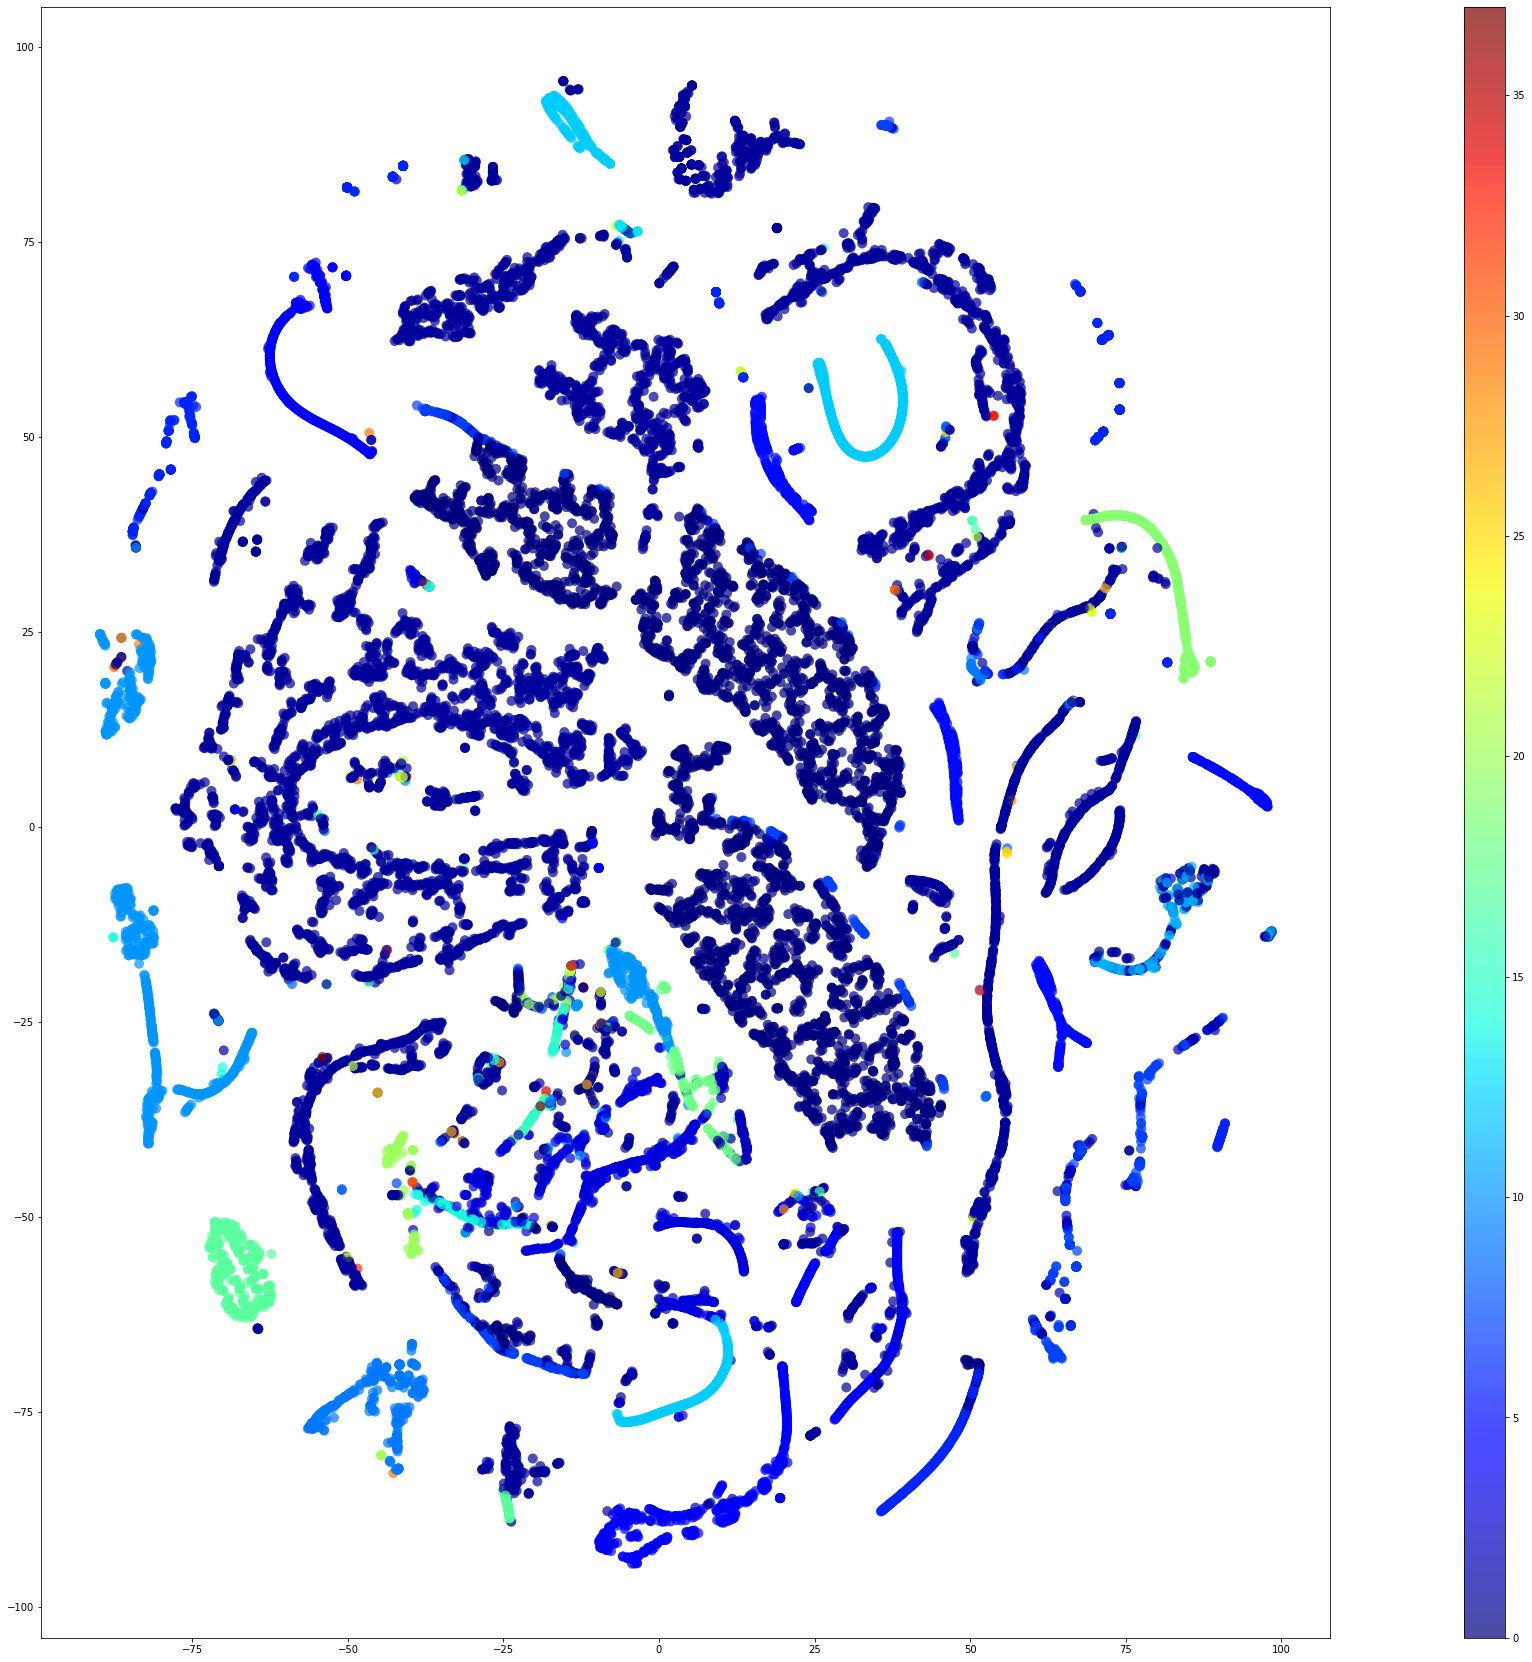

In [16]:
plt.figure(figsize = (30, 30))
# lbl = dataset_dict['train'][:][1][i]
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1],
            c=dataset_dict['test'][:][1].detach().numpy(), 
            cmap=plt.cm.jet, 
            edgecolor='none', 
            # label = lbl,
            alpha=0.7,
            s=100)

plt.colorbar(aspect=40, pad=0.08, orientation='vertical')

In [8]:
len(dataset_dict['train'])

25192

In [17]:
# build dataloader
dataloader_dict = data_manager.build_dataloader(len(dataset_dict['train']))

# build model, optimizer
channel_in = data_manager.get_channel_in()
num_classes = data_manager.get_num_classes()
# model = ResNetMetricModel(channel_in=channel_in, feature_dim=feature_dim, output_dim=num_classes)
# model = ResNet18(num_classes=feature_dim)
model = MLP(in_features=data_manager.input_dim, out_features=feature_dim)
metric_layer = ArcMarginProduct(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.50, easy_margin=False)
optimizer = optim.Adam(list(model.parameters()) + list(metric_layer.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss()

In [18]:
model = model.to(device)
metric_layer = metric_layer.to(device)

In [19]:
load_epoch = 49
model_path = '../models/kdd/model_epoch_{}.pth'.format(load_epoch)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [20]:
for i, (data, label) in enumerate(dataloader_dict['test']):
    data = data.to(device)
    emb = model(data)
    print(i)

0


In [21]:
emb.size()

torch.Size([22544, 128])

In [22]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)

X_embedded = tsne.fit_transform(emb.cpu().detach().numpy())

C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [26]:
dataset_dict['train'][:][1].detach().numpy()[0]

0

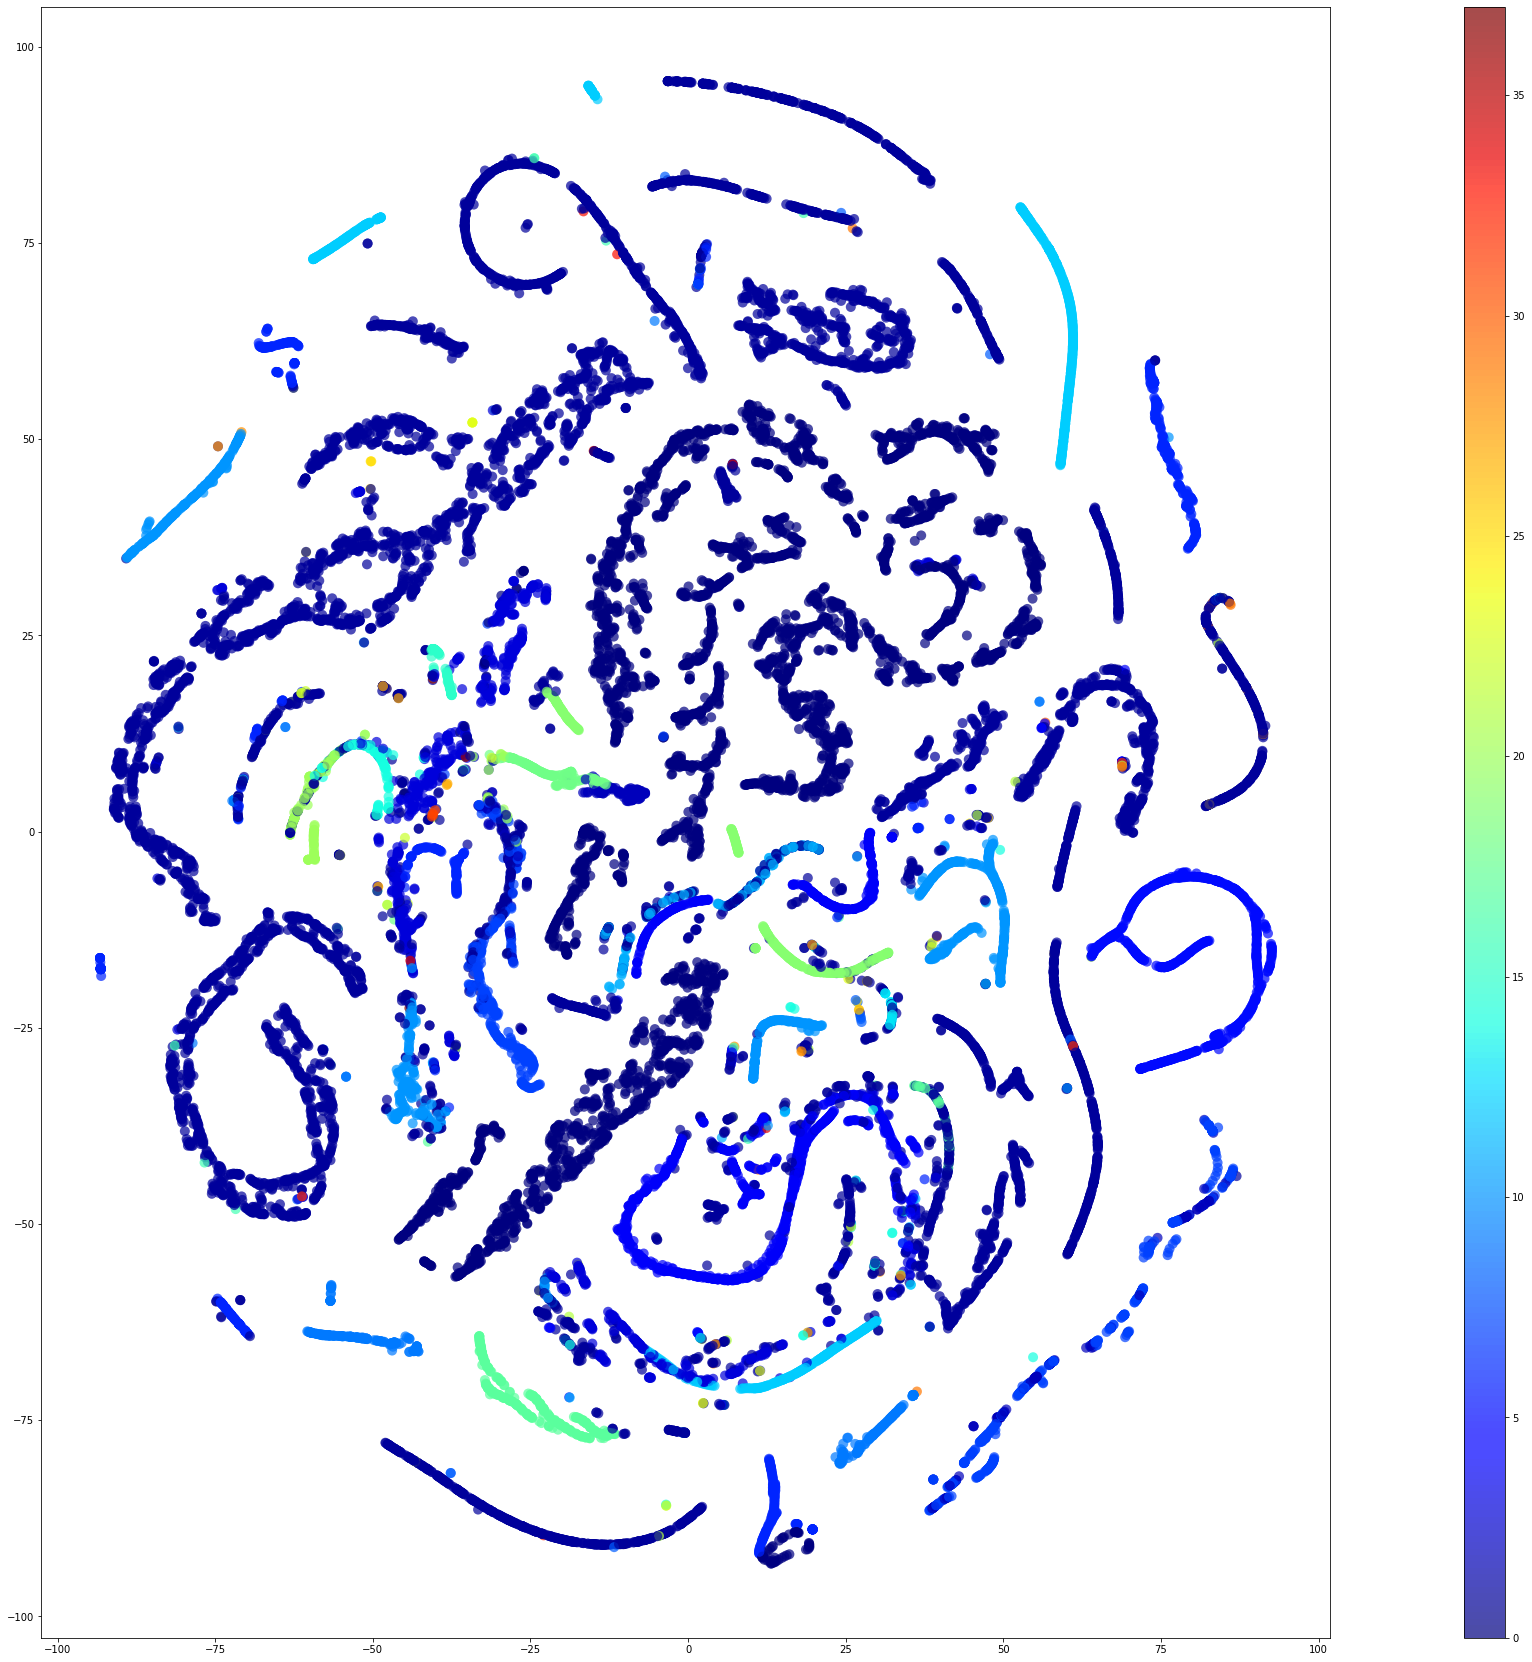

In [28]:
plt.figure(figsize = (30, 30))
# lbl = dataset_dict['train'][:][1][i]
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1],
            c=dataset_dict['test'][:][1].detach().numpy(), 
            cmap=plt.cm.jet, 
            edgecolor='none', 
            # label = lbl,
            alpha=0.7,
            s=100)

plt.colorbar(aspect=40, pad=0.08, orientation='vertical')

In [36]:
for data, label in dataloader_dict['train']:
    data = data.to(device)
    label = label.to(device)

    feature = model(data)
    output = metric_layer(feature, label)
    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

In [ ]:
# train model
trainer = Trainer(model, metric_layer, optimizer, criterion, device, model_dir='../models', result_dir='../results')
trainer.train_model(dataloader_dict, max_epoch, save_interval=1, save_flag=True)